## Initial Data Cleaning ##

Collects and unifies primary and secondary school data where the anonymized student is present in both.

In [1]:
import csv
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata 

In [2]:
def remove_accents(text):
    if pd.isna(text):
        return text
    # Normalize unicode and remove combining diacritics
    return ''.join(
        c for c in unicodedata.normalize('NFKD', str(text))
        if not unicodedata.combining(c)
    )

def summarize(df, column):
    if column not in df.columns:
        print(f"Column '{column}' not found in dataframe.")
        return
    
    series = df[column].dropna()
    print(f"--- Summary for: {column} ---")
    print(f"Count:      {series.count()}")
    print(f"Mean:       {series.mean():.2f}")
    print(f"Median:     {series.median():.2f}")
    print(f"Std Dev:    {series.std():.2f}")
    print(f"Min:        {series.min():.2f}")
    print(f"Max:        {series.max():.2f}")
    print("\nPercentiles:")
    print(series.quantile([0.1, 0.25, 0.5, 0.75, 0.9]))
    print()
def group_summary(df, group_col, value_col):

    if group_col not in df.columns:
        raise ValueError(f"Group column '{group_col}' not found.")
    if value_col not in df.columns:
        raise ValueError(f"Value column '{value_col}' not found.")

    summary = (
        df.groupby(group_col)[value_col]
          .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
          .sort_values('mean', ascending=False)
    )
    return summary

def clean_colname(col):
    col = ''.join(c for c in unicodedata.normalize('NFKD', str(col)) if not unicodedata.combining(c))
    col = col.upper().replace(' ', '_')
    return col

def clean_column(series):

    series = series.astype(str)
    series = series.replace(r'^\s*$', pd.NA, regex=True)
    series = series.str.replace(',', '.', regex=False)
    series = pd.to_numeric(series, errors='coerce')

    return series

def grouped_stats(df, group_col, value_cols, stats=None):
    if stats is None:
        stats = ['count', 'mean', 'median', 'std', 'min', 'max']

    if isinstance(value_cols, str):
        value_cols = [value_cols]

    result = {}

    for col in value_cols:
        if col not in df.columns:
            continue
        df_clean = df.dropna(subset=[col])
        result[col] = df_clean.groupby(group_col)[col].agg(stats)

    return result

def plot_histogram(df, col, bins=20, kde=True):
    if col not in df.columns:
        print(f"{col} not in DataFrame")
        return
    
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col].dropna(), bins=bins, kde=kde)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.tick_params(axis='x', labelrotation=90)
    plt.ylabel("Count")
    plt.show()

def load_csv_clean(path):
    data = []
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            data.append(row)

    df = pd.DataFrame(data)
    
    df.columns = df.iloc[0]
    df = df[1:].reset_index(drop=True)
    df.columns = [clean_colname(col) for col in df.columns]
    
    return df


In [3]:
df_S = load_csv_clean("../Data/Avaluació_de_quart_d’Educació_Secundària_Obligatòria_20251110.csv")
df_P = load_csv_clean("../Data/Avaluació_de_sisè_d'educació_primària_20251110.csv")

In [4]:
df_P.columns

Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PMAT', 'PMAT_NC', 'PMAT_EFM', 'PMAT_CR', 'PANG', 'PANG_CO',
       'PANG_CE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CE', 'PANG_EE', 'PFRAN_EE',
       'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3',
       'GENERE', 'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'AREA_TERRITORIAL',
       'NATURALESA', 'HABITAT'],
      dtype='object')

In [ ]:
shared_cols = [
    'ANY', 'ANY_NAIXEMENT', 'CODI_ALUMNE', 'MES_NAIXEMENT',
    'PANG','PANG_CO','PANG_EE','PCAST','PCAST_CL','PCAST_EE',
    'PCAT','PCAT_CL','PCAT_EE','PFRAN','PFRAN_CO','PFRAN_EE',
    'PMAT','PMAT_CR','PMAT_EFM','PMAT_NC'
]

shared_cols = df_S.columns.intersection(df_P.columns)

# Keep only rows where CODI_ALUMNE exists
df_P = df_P.dropna(subset=['CODI_ALUMNE']).copy()
df_S = df_S.dropna(subset=['CODI_ALUMNE']).copy()

# Keep only rows where CODI_ALUMNE is not NaN and not an empty string
df_S = df_S[df_S['CODI_ALUMNE'].notna() & (df_S['CODI_ALUMNE'].astype(str).str.strip() != "")].copy()
df_P = df_P[df_P['CODI_ALUMNE'].notna() & (df_P['CODI_ALUMNE'].astype(str).str.strip() != "")].copy()


# Convert CODI_ALUMNE to int
df_P['CODI_ALUMNE'] = df_P['CODI_ALUMNE'].astype(int)
df_S['CODI_ALUMNE'] = df_S['CODI_ALUMNE'].astype(int)

# Drop duplicate IDS
df_P["CODI_ALUMNE"].drop_duplicates()
df_S["CODI_ALUMNE"].drop_duplicates()

# Keep only students present in both datasets
common_ids = set(df_P['CODI_ALUMNE']).intersection(df_S['CODI_ALUMNE'])
df_P = df_P[df_P['CODI_ALUMNE'].isin(common_ids)].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(common_ids)].copy()

# Keep only shared columns that exist in both
df_P = df_P[shared_cols].copy()
df_S = df_S[shared_cols].copy()

# Add LEVEL column
df_P['LEVEL'] = 'PRIMARIA'
df_S['LEVEL'] = 'SECUNDARIA'

csv_path = "../Data/Secundaria.csv"
df_S.to_csv(csv_path)

csv_path = "../Data/Primaria.csv"
df_P.to_csv(csv_path)



In [6]:
df_s = pd.read_csv("../Data/Secundaria.csv", header=0)
df_p = pd.read_csv("../Data/Primaria.csv", header=0)

/var/folders/_m/vj49vq3972b166bph370j1kw0000gn/T/ipykernel_38727/2659143188.py:1: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_s = pd.read_csv("../Data/Secundaria.csv", header=0)


In [12]:
df_s.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df_p.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [16]:
cols_to_clean = [
    'ANY', 'ANY_NAIXEMENT', 'MES_NAIXEMENT',
    'PANG','PANG_CO','PANG_EE','PCAST','PCAST_CL','PCAST_EE',
    'PCAT','PCAT_CL','PCAT_EE','PFRAN','PFRAN_CO','PFRAN_EE',
    'PMAT','PMAT_CR','PMAT_EFM','PMAT_NC'
]

# euro decimal -> decimal
for col in cols_to_clean:
    if col in df_s.columns:
        df_s[col] = (
            df_s[col]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .astype(float)
        )
        
    if col in df_p.columns:
        
        df_p[col] = (
            df_p[col]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .astype(float)
        )

df_p['CODI_ALUMNE'] = df_p['CODI_ALUMNE'].astype(int)
df_s['CODI_ALUMNE'] = df_s['CODI_ALUMNE'].astype(int)
       

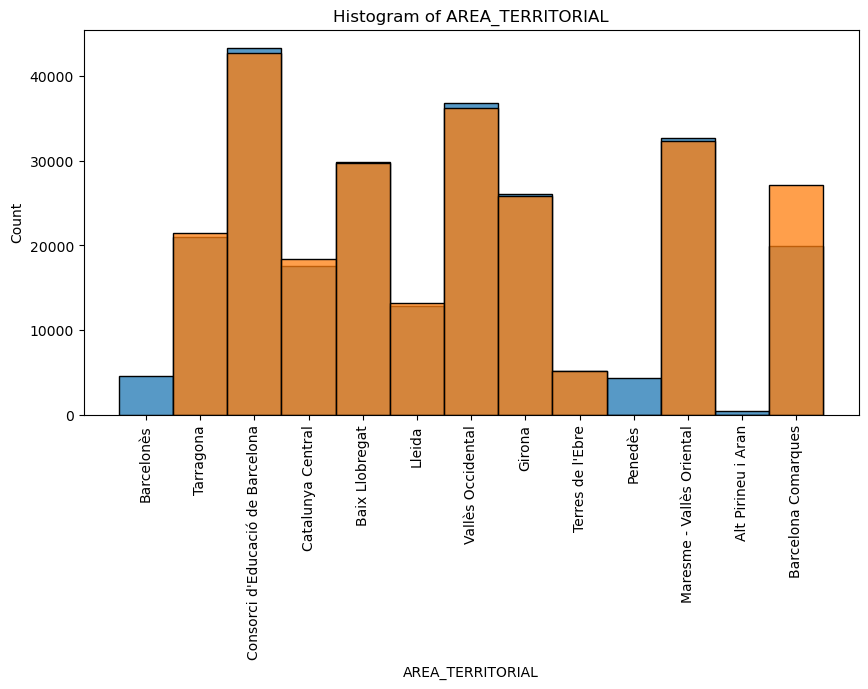

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df_s["AREA_TERRITORIAL"].dropna(), kde=False)
sns.histplot(df_p["AREA_TERRITORIAL"].dropna(), kde=False)
plt.title(f"Histogram of AREA_TERRITORIAL")
plt.xlabel("AREA_TERRITORIAL")
plt.tick_params(axis='x', labelrotation=90)
plt.ylabel("Count")
plt.show()

In [25]:
explore=['CODI_ALUMNE',
 'ANY',
 'ANY_NAIXEMENT',
 'MES_NAIXEMENT',
 'GENERE',
 'AREA_TERRITORIAL',
 'NATURALESA',
 'HABITAT',
 'PANG',
 'PCAST',
 'PCAT',
 'PFRAN',
 'PMAT',
 ]

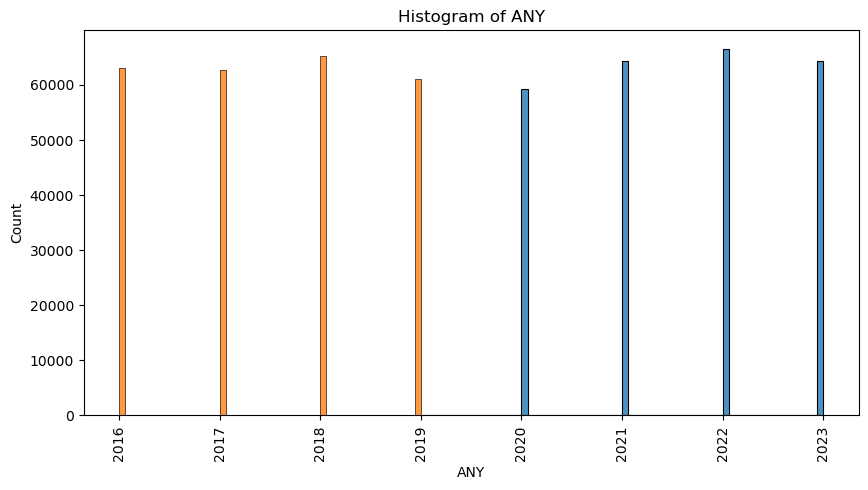

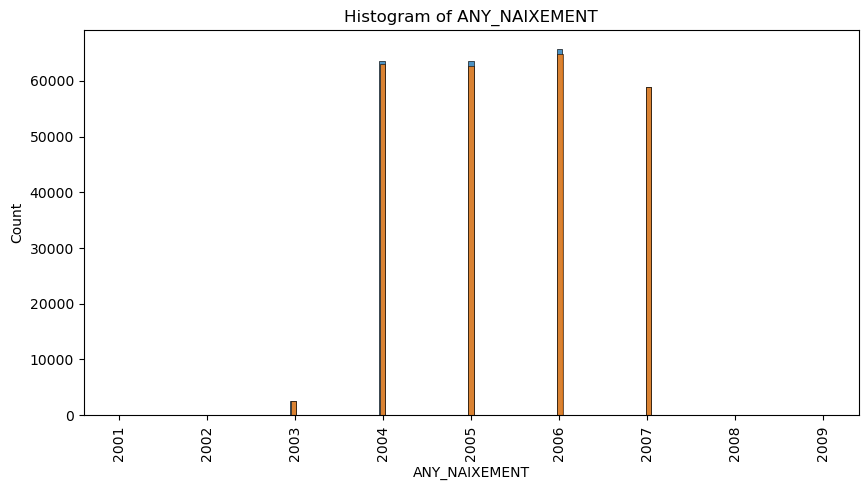

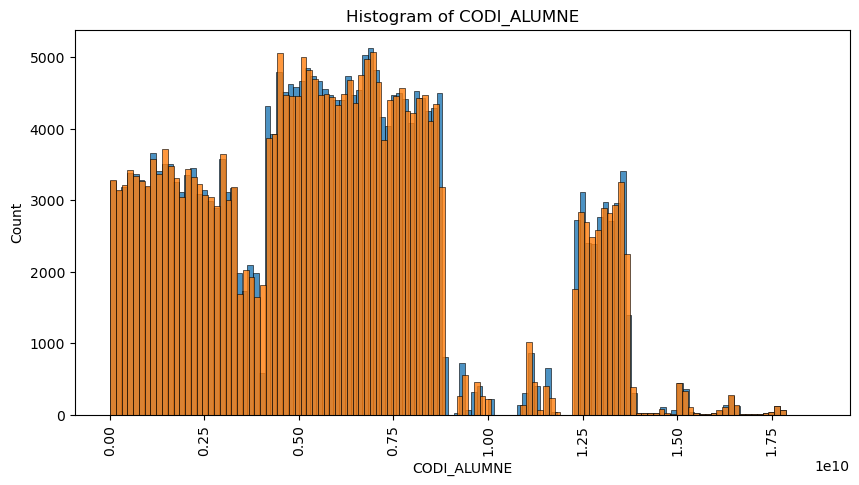

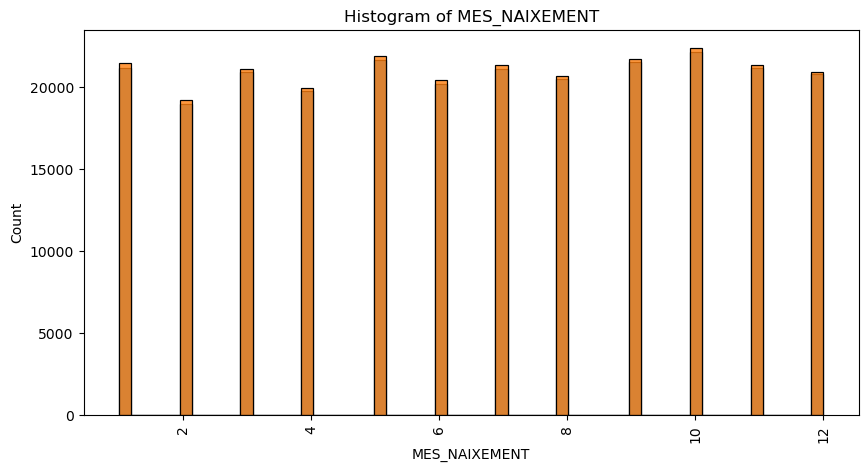

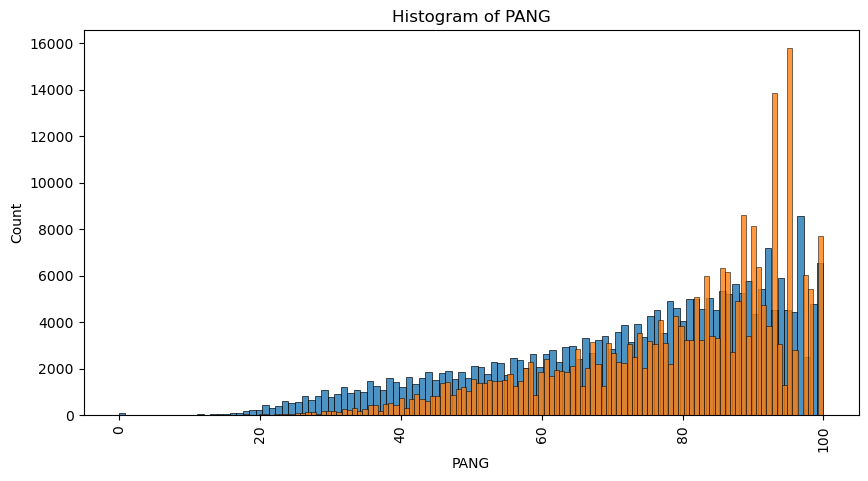

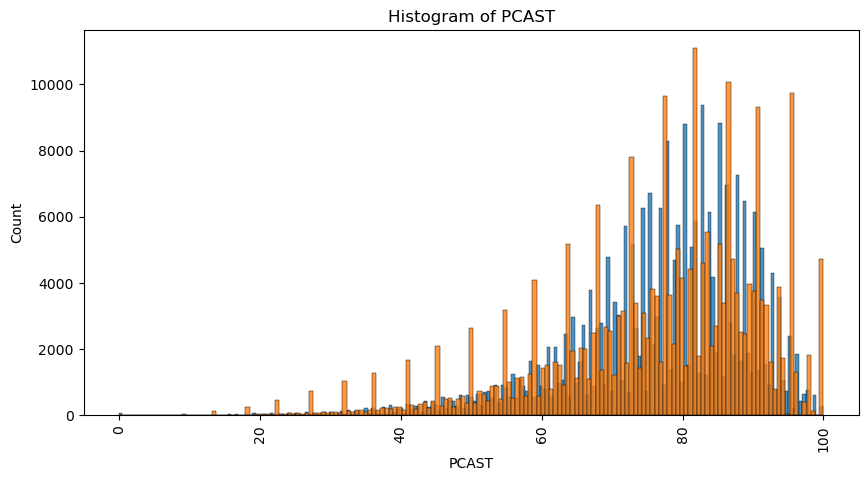

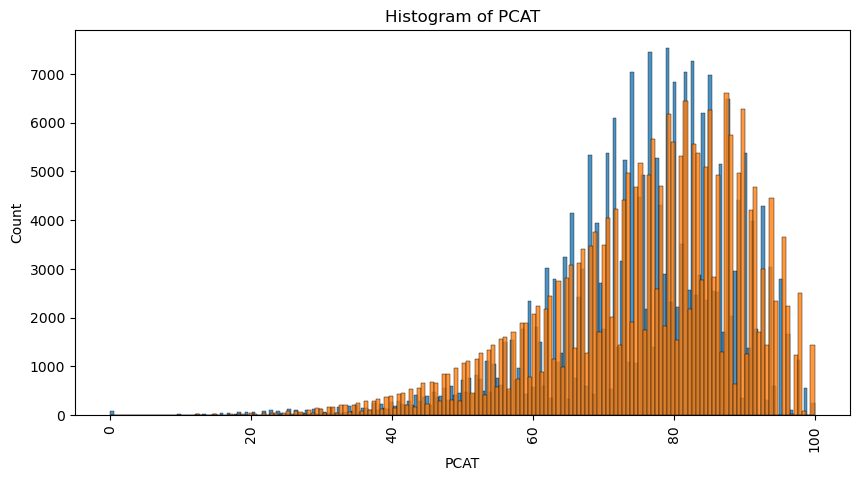

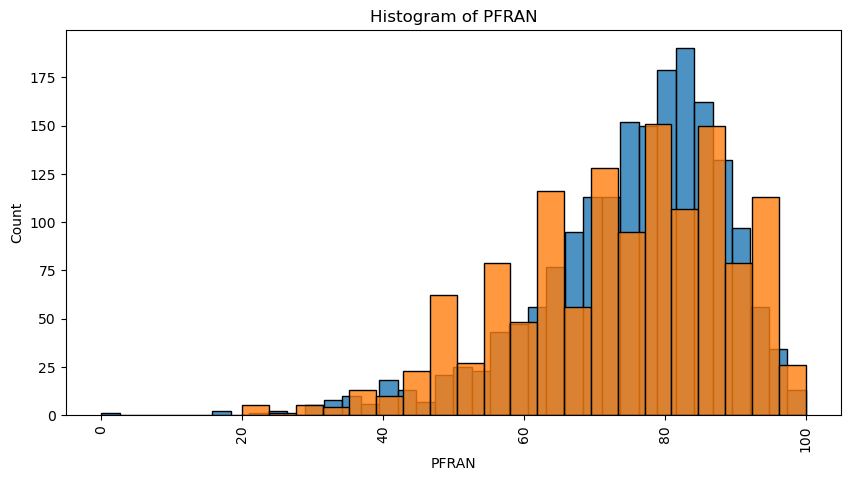

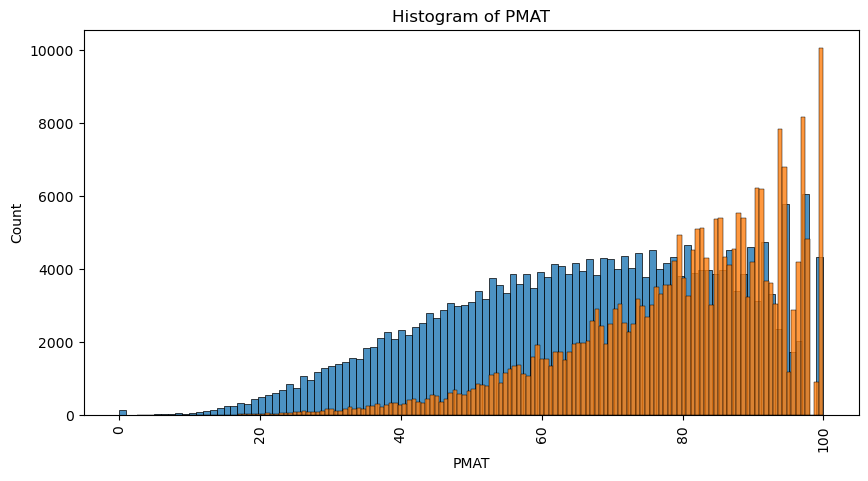

In [20]:
#plot_histogram(df_p_final, "AREA_TERRITORIAL", bins=20, kde=False)
for c in explore:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_s[c].dropna(), alpha=0.8, kde=False)
    sns.histplot(df_p[c].dropna(), alpha=0.8, kde=False)
    plt.title(f"Histogram of {c}")
    plt.xlabel(c)
    plt.tick_params(axis='x', labelrotation=90)
    plt.ylabel("Count")
    plt.show()
    #plot_histogram(df_s,c, bins=100, kde=False)


In [15]:
df_s

,Unnamed: 0,ANY,CODI_ALUMNE,PCAT,PCAT_CL,PCAT_EE,PCAST,PCAST_CL,PCAST_EE,PANG,...,PMAT_EFM,PMAT_CR,PMAT_NC,GENERE,MES_NAIXEMENT,ANY_NAIXEMENT,NATURALESA,AREA_TERRITORIAL,HABITAT,LEVEL
0,0,2023.0,3.901524e+09,75.23,73.75,78.13,79.40,74.0,87.50,78.4,...,75.00,87.50,77.78,H,6.0,2007.0,Privada,Barcelonès,De 10001 a 100000,SECUNDARIA
1,1,2023.0,3.903494e+09,65.61,70.11,59.38,74.55,68.0,84.38,74.0,...,50.00,75.00,77.78,H,9.0,2007.0,Privada,Barcelonès,De 10001 a 100000,SECUNDARIA
2,2,2023.0,4.328916e+09,38.11,53.71,15.63,50.70,72.0,18.75,56.0,...,12.50,62.50,22.22,H,7.0,2007.0,Privada,Barcelonès,De 10001 a 100000,SECUNDARIA
3,3,2023.0,3.901434e+09,89.37,90.15,87.50,86.45,92.0,78.13,88.8,...,75.00,100.00,77.78,H,5.0,2007.0,Privada,Barcelonès,De 10001 a 100000,SECUNDARIA
4,4,2023.0,3.900118e+09,65.56,71.93,56.25,63.35,66.0,59.38,66.6,...,25.00,37.50,55.56,H,8.0,2006.0,Privada,Barcelonès,De 10001 a 100000,SECUNDARIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254512,351547,2019.0,2.446417e+09,50.70,72.00,18.75,90.10,96.0,81.25,NaN,...,100.00,100.00,100.00,D,4.0,2004.0,Privada,Barcelona Comarques,Més de 100000,SECUNDARIA
254513,352825,2019.0,2.063526e+09,83.00,80.00,87.50,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,H,9.0,2003.0,Pública,Girona,Fins a 10000,SECUNDARIA
254514,352831,2019.0,2.057014e+09,81.90,74.00,93.75,70.55,78.0,59.38,100.0,...,33.33,63.64,37.50,H,7.0,2004.0,Pública,Girona,Fins a 10000,SECUNDARIA
254515,355529,2019.0,7.120636e+09,86.45,92.00,78.13,93.95,92.0,96.88,NaN,...,100.00,100.00,100.00,H,5.0,2004.0,Pública,Barcelona Comarques,De 10001 a 100000,SECUNDARIA


In [26]:
explore=['CODI_ALUMNE',
 'ANY',
 'ANY_NAIXEMENT',
 'MES_NAIXEMENT',
 'GENERE',
 'AREA_TERRITORIAL',
 'NATURALESA',
 'HABITAT',
 'PANG',
 'PCAST',
 'PCAT',
 'PFRAN',
 'PMAT',
 ]
# Combine datasets
df_combined = pd.concat([df_p, df_s], ignore_index=True)

# Pivot table: one row per student, separate columns per LEVEL
df_pivot = df_combined.pivot_table(
    index='CODI_ALUMNE',
    columns='LEVEL',
    values=[col for col in explore if col != 'CODI_ALUMNE'],
    aggfunc='first'
)

# Reset index if needed
df_pivot.reset_index(inplace=True)

In [33]:
grouped_stats = df_s.groupby('AREA_TERRITORIAL')[[f'{col}' for col in ['PANG','PCAST','PCAT','PFRAN','PMAT']]].describe()

In [34]:
grouped_stats

PANG                                    \
                                    count       mean        std   min   25%   
AREA_TERRITORIAL                                                              
Alt Pirineu i Aran                  440.0  75.408182  19.408049  20.4  63.1   
Baix Llobregat                    29277.0  72.081713  19.847396   0.0  58.6   
Barcelona Comarques               19415.0  70.584141  20.285772   0.0  56.4   
Barcelonès                         4427.0  73.197335  19.640563   8.0  59.8   
Catalunya Central                 17016.0  72.717513  20.197037   0.0  59.2   
Consorci d'Educació de Barcelona  41940.0  77.569194  18.297609   0.0  67.6   
Girona                            25176.0  72.785435  19.867666   0.0  59.8   
Lleida                            12500.0  74.662584  19.092251  10.0  62.2   
Maresme - Vallès Oriental         31942.0  73.237080  19.156266   0.0  60.8   
Penedès                            4161.0  72.367316  20.451847   0.0  58.2   
Tarragona                         20043.0  70.575313  20.725405   0.0  55.4   
Terres de l'Ebre                   4985.0  71.252477  19.180221  13.2  57.6   
Vallès Occidental                 35548.0  72.056209  20.688905   0.0  58.0   

                                                       PCAST             ...  \
                                   50%   75%    max    count       mean  ...   
AREA_TERRITORIAL                                                         ...   
Alt Pirineu i Aran                80.4  91.0  100.0    453.0  74.779139  ...   
Baix Llobregat                    76.2  88.2  100.0  29403.0  77.364239  ...   
Barcelona Comarques               74.6  87.4  100.0  19626.0  77.334439  ...   
Barcelonès                        77.2  89.2  100.0   4445.0  72.803003  ...   
Catalunya Central                 77.2  89.4  100.0  17200.0  75.910653  ...   
Consorci d'Educació de Barcelona  82.4  91.8  100.0  42624.0  78.113566  ...   
Girona                            77.2  89.0  100.0  25561.0  75.883967  ...   
Lleida                            79.1  90.0  100.0  12705.0  77.296098  ...   
Maresme - Vallès Oriental         77.3  88.8  100.0  32380.0  77.186744  ...   
Penedès                           77.0  89.0  100.0   4273.0  71.427323  ...   
Tarragona                         74.6  87.8  100.0  20659.0  75.930202  ...   
Terres de l'Ebre                  74.2  87.0  100.0   5104.0  78.083366  ...   
Vallès Occidental                 76.8  89.2  100.0  36130.0  76.553614  ...   

                                  PFRAN            PMAT                        \
                                    75%    max    count       mean        std   
AREA_TERRITORIAL                                                                
Alt Pirineu i Aran                80.60   93.4    454.0  62.875441  18.065697   
Baix Llobregat                      NaN    NaN  29394.0  65.712991  19.921070   
Barcelona Comarques               81.40   95.4  19610.0  65.481726  20.431526   
Barcelonès                          NaN    NaN   4446.0  61.695684  19.371872   
Catalunya Central                 82.80   98.4  17243.0  66.038649  20.447664   
Consorci d'Educació de Barcelona  85.40   98.4  42634.0  69.008160  19.967734   
Girona                            83.90   98.4  25655.0  66.704579  20.443485   
Lleida                            86.50   96.8  12722.0  67.708347  19.944472   
Maresme - Vallès Oriental         85.55   97.0  32414.0  66.713010  19.635119   
Penedès                           82.20   92.8   4276.0  61.196356  20.002616   
Tarragona                         84.80   98.0  20647.0  65.526225  20.246105   
Terres de l'Ebre                  85.40   91.4   5107.0  66.634813  19.253512   
Vallès Occidental                 85.60  100.0  36181.0  65.501886  20.494324   

                                                                         
                                    min      25%     50%     75%    max  
AREA_TERRITORIAL                              